In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!python --version

Python 3.7.13


In [ ]:
%%time
# Check if NVIDIA GPU runtime is selected and available
!nvidia-smi

Tue Sep 13 10:48:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   6828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive                 #mount google drive with colab
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzipping file
!unzip /content/gdrive/MyDrive/ricedataset.zip

Archive:  /content/gdrive/MyDrive/ricedataset.zip
replace ricedataset/Arborio/Arborio (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ricedataset/Arborio/Arborio (10).jpg  
replace ricedataset/Arborio/Arborio (10006).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ricedataset/Arborio/Arborio (10028).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
IMAGE_SIZE = 250
batch_size = 32
channels = 3
EPOCHS  = 20

In [ ]:
pwd

'/content'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"/content/ricedataset",
shuffle = True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size =batch_size)

Found 75000 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [ ]:
len(dataset)

2344

In [ ]:
# for image_batch, label_batch in dataset.take(1):
#     pass

for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

(32, 250, 250, 3)


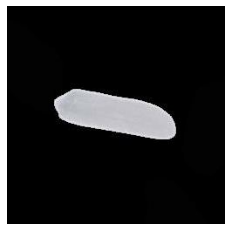

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")

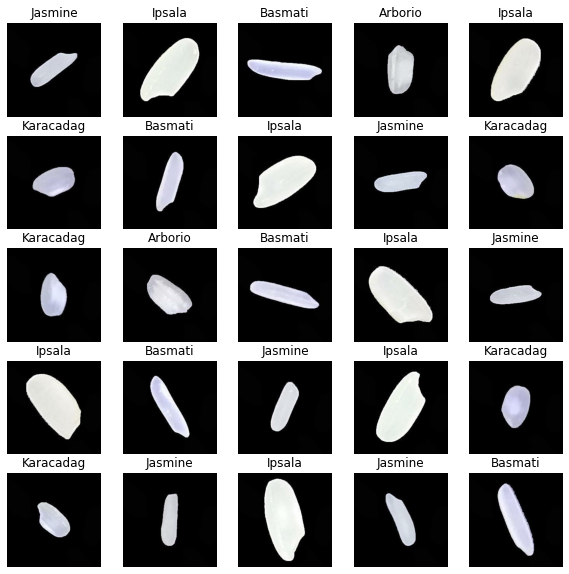

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.7,val_split = 0.2,test_split=0.1,shuffle=True,shuffle_size = 100):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 20)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_argumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (batch_size,IMAGE_SIZE,IMAGE_SIZE,channels)
n_classes = 5

model = models.Sequential([
     resize_and_rescale,
     data_argumentation,
     
     layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
     layers.MaxPooling2D((2,2)),
     
     layers.Conv2D(64, kernel_size = (3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     
     layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
     
     layers.Conv2D(64,(3,3),activation='relu'),
     layers.MaxPooling2D((2,2)),
    
     layers.Flatten(), 
     
     layers.Dense(64,activation='relu'),
     layers.Dense(n_classes,activation='softmax')
     
 ])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 250, 250, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 250, 250, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 248, 248, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 124, 124, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 122, 122, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 61, 61, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] 
)

In [ ]:
len(train_ds)

1640

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=2, mode='auto',
    baseline=None, restore_best_weights=True
)

In [ ]:
#over gpu runtime
%%time
histroy = model.fit(train_ds,epochs=5,batch_size = 64,validation_data =val_ds,callbacks=[early_stopping])

Epoch 1/5
1640/1640 [==============================] - 200s 120ms/step - loss: 0.1582 - accuracy: 0.9435 - val_loss: 0.1215 - val_accuracy: 0.9591
Epoch 2/5
1640/1640 [==============================] - 176s 105ms/step - loss: 0.1060 - accuracy: 0.9639 - val_loss: 0.0642 - val_accuracy: 0.9800
Epoch 3/5
1640/1640 [==============================] - 175s 105ms/step - loss: 0.0497 - accuracy: 0.9839 - val_loss: 0.0247 - val_accuracy: 0.9916
Epoch 4/5
1640/1640 [==============================] - 173s 104ms/step - loss: 0.0336 - accuracy: 0.9895 - val_loss: 0.0332 - val_accuracy: 0.9890
Epoch 5/5
1640/1640 [==============================] - 172s 104ms/step - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0183 - val_accuracy: 0.9939
CPU times: user 18min 59s, sys: 1min 40s, total: 20min 39s
Wall time: 16min 49s


In [ ]:
#colab is good to go for testing models.

In [ ]:
scores = model.evaluate(test_ds)

236/236 [==============================] - 54s 34ms/step - loss: 0.0167 - accuracy: 0.9947


In [ ]:
scores

[0.016711395233869553, 0.9946977496147156]

In [ ]:
histroy

In [ ]:
histroy.params

{'verbose': 1, 'epochs': 5, 'steps': 1640}

In [ ]:
histroy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
histroy.history['accuracy']

[0.9434641599655151,
 0.963871955871582,
 0.9839367270469666,
 0.9895198345184326,
 0.9914443492889404]

In [ ]:
acc = histroy.history['accuracy']
val_acc = histroy.history['val_accuracy']

loss = histroy.history['loss']
val_loss = histroy.history['val_loss']

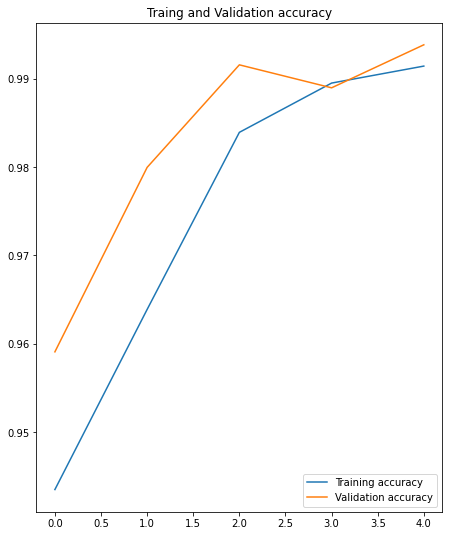

In [ ]:
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(acc,label = 'Training accuracy')
plt.plot(val_acc,label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Traing and Validation accuracy')
plt.show()

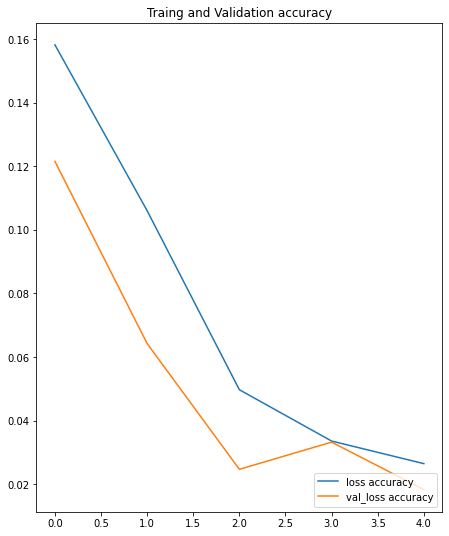

In [ ]:
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(loss,label = 'loss accuracy')
plt.plot(val_loss,label = 'val_loss accuracy')
plt.legend(loc='lower right')
plt.title('Traing and Validation accuracy')
plt.show()

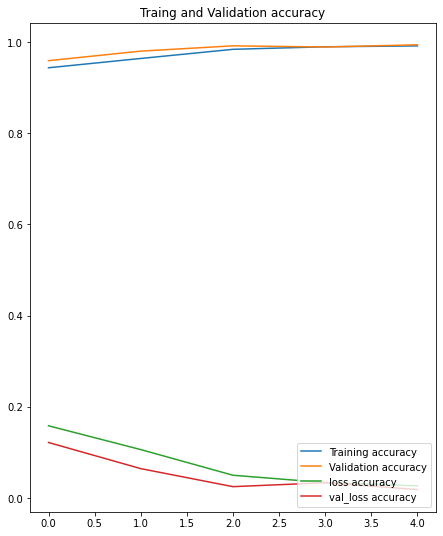

In [ ]:
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(acc,label = 'Training accuracy')
plt.plot(val_acc,label = 'Validation accuracy')
plt.plot(loss,label = 'loss accuracy')
plt.plot(val_loss,label = 'val_loss accuracy')
plt.legend(loc='lower right')
plt.title('Traing and Validation accuracy')
plt.show()

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

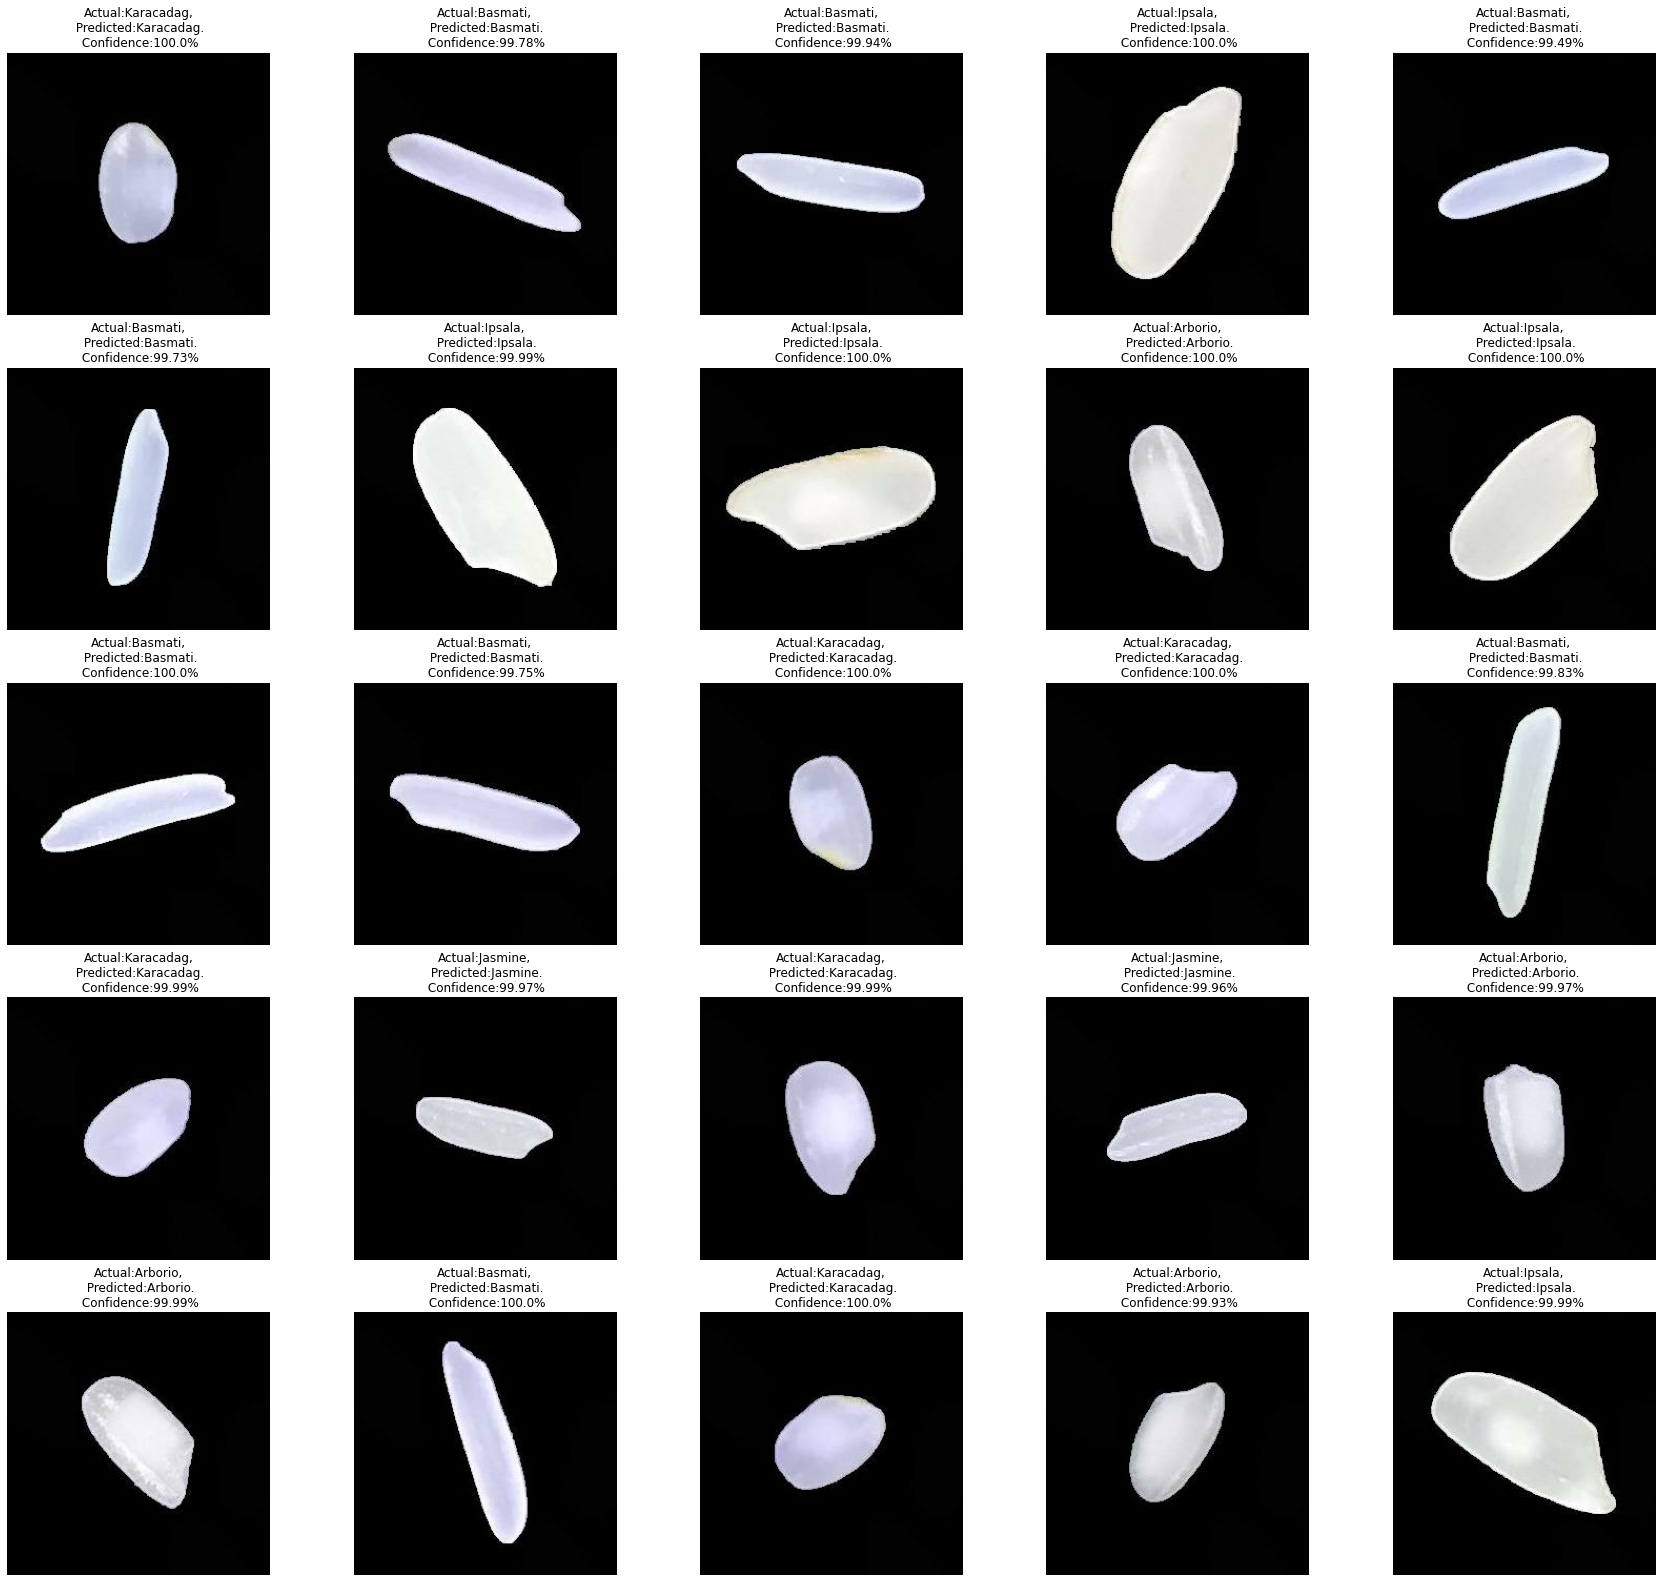

In [ ]:
plt.figure(figsize=(30,28))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%",size = 12)
        plt.axis('off')